In [9]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
import wfdb
import copy as cp
import scipy.signal as signal
import pickle
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import csv

from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from time import time
import timeit

In [10]:
record_list = [] # Initialize the array that will hold the list of our records

records = 'mit-bih-dataframes/subject_list.csv' # Get our record list like we did in the initial extraction
with open(records) as rfile:# Load our records into the array
    for record in rfile:
        record = record[0:-1] # The -1 removes the newline ("\n") character from the string
        record_list.append(record)

In [11]:
dfdic = {}
for idx, x in enumerate(record_list):
    dfdic[x] = pd.read_csv('mit-bih-features/'+x+ '.csv', index_col=0)

In [12]:
subject_df = pd.DataFrame()
for idx, x in enumerate(record_list):
    subject_df = pd.concat([subject_df, dfdic[x]])

In [13]:
subject_df['Mappedrhythmlabels'] = subject_df['rhythmLabel'].map({'Normal':0, 'Other':0, 'AFIB':1})

In [14]:
subject_df.head()

,subsetID,rhythmLabel,StoS,StoR,StoL,RtoS,RtoR,RtoL,LtoS,LtoR,LtoL,RMS,STD,CoefVar,Range,IQR,MAD,Mappedrhythmlabels
0,04015-0.csv,Normal,0.200000,0.057143,0.028571,0.057143,0.228571,0.142857,0.057143,0.114286,0.114286,156.276998,43.660906,0.248152,155.0,78.00,32.5,0
1,04015-1.csv,Normal,0.000000,0.052632,0.000000,0.052632,0.184211,0.236842,0.000000,0.210526,0.263158,197.783973,57.233572,0.355262,213.0,93.50,55.0,0
2,04015-2.csv,Normal,0.333333,0.083333,0.055556,0.027778,0.305556,0.083333,0.111111,0.000000,0.000000,151.638551,43.820505,0.253179,138.0,72.00,56.0,0
3,04015-3.csv,Normal,0.300000,0.175000,0.000000,0.125000,0.025000,0.125000,0.075000,0.050000,0.125000,157.611865,48.827831,0.318730,167.0,79.00,59.0,0
4,04015-4.csv,Normal,0.090909,0.151515,0.090909,0.030303,0.060606,0.212121,0.212121,0.060606,0.090909,226.855681,53.260256,0.289227,237.0,95.75,66.5,0


In [15]:
statiqr_dic = {
    'Run Time': [],
    'Accuracy': [],
    'Standard Error': [],
    'Sensitivity': [],
    'Specificity': [],
    'Precision': [],
    'F1_Score': []
}

indaccs = {}

In [16]:
#Logistic Regression

kf = KFold(n_splits=5, random_state=3, shuffle=True)
model = LogisticRegression(solver='liblinear')

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df): 
    
    X_train = subject_df.iloc[train_index, 15].values.reshape(-1,1)
    X_test = subject_df.iloc[test_index, 15].values.reshape(-1,1)
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statiqr_dic['Run Time'].append(elapsed)
statiqr_dic['Accuracy'].append(np.mean(acc_score))
statiqr_dic['Standard Error'].append(np.std(acc_score))
statiqr_dic['Sensitivity'].append(sensitivity)
statiqr_dic['Specificity'].append(specificity)
statiqr_dic['Precision'].append(precision)
statiqr_dic['F1_Score'].append(f1_score)

indaccs['LogReg'] = acc_score

---Run time is 0.21087628399999403 seconds ---

Accuracy of each fold: 
 [0.8867662917886304, 0.8815100154083205, 0.8889060092449923, 0.889060092449923, 0.8956856702619415]
Avg accuracy: 0.8883856158307616
Std of accuracy : 
0.004558785238110142

[[18329  1097]
 [ 2525 10500]]

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     19426
           1       0.91      0.81      0.85     13025

    accuracy                           0.89     32451
   macro avg       0.89      0.87      0.88     32451
weighted avg       0.89      0.89      0.89     32451

0.9435292906414084
0.8061420345489443
0.8789201112496403
0.9100794438927508


In [17]:
#LDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=LinearDiscriminantAnalysis()

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df):
    X_train = subject_df.iloc[train_index, 15].values.reshape(-1,1)
    X_test = subject_df.iloc[test_index, 15].values.reshape(-1,1)
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)
    

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statiqr_dic['Run Time'].append(elapsed)
statiqr_dic['Accuracy'].append(np.mean(acc_score))
statiqr_dic['Standard Error'].append(np.std(acc_score))
statiqr_dic['Sensitivity'].append(sensitivity)
statiqr_dic['Specificity'].append(specificity)
statiqr_dic['Precision'].append(precision)
statiqr_dic['F1_Score'].append(f1_score)

indaccs['LDA'] = acc_score

---Run time is 0.1330119360000026 seconds ---

Accuracy of each fold: 
 [0.8718225234940687, 0.8659476117103235, 0.8691833590138675, 0.8722650231124808, 0.8765793528505393]
Avg accuracy: 0.871159574036256
Std of accuracy : 
0.003524358073214143

[[18492   934]
 [ 3247  9778]]

              precision    recall  f1-score   support

           0       0.85      0.95      0.90     19426
           1       0.91      0.75      0.82     13025

    accuracy                           0.87     32451
   macro avg       0.88      0.85      0.86     32451
weighted avg       0.88      0.87      0.87     32451

0.9519201070729949
0.7507101727447217
0.8506371038226229
0.8984331349447345


In [18]:
#QDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=QuadraticDiscriminantAnalysis()

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df):
    
    X_train = subject_df.iloc[train_index, 15].values.reshape(-1,1)
    X_test = subject_df.iloc[test_index, 15].values.reshape(-1,1)
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)
    

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statiqr_dic['Run Time'].append(elapsed)
statiqr_dic['Accuracy'].append(np.mean(acc_score))
statiqr_dic['Standard Error'].append(np.std(acc_score))
statiqr_dic['Sensitivity'].append(sensitivity)
statiqr_dic['Specificity'].append(specificity)
statiqr_dic['Precision'].append(precision)
statiqr_dic['F1_Score'].append(f1_score)

indaccs['QDA'] = acc_score

---Run time is 0.10882736199999954 seconds ---

Accuracy of each fold: 
 [0.8718225234940687, 0.8659476117103235, 0.8691833590138675, 0.8731895223420647, 0.8765793528505393]
Avg accuracy: 0.8713444738821728
Std of accuracy : 
0.003600922988351119

[[18490   936]
 [ 3239  9786]]

              precision    recall  f1-score   support

           0       0.85      0.95      0.90     19426
           1       0.91      0.75      0.82     13025

    accuracy                           0.87     32451
   macro avg       0.88      0.85      0.86     32451
weighted avg       0.88      0.87      0.87     32451

0.9518171522701534
0.7513243761996161
0.8509365364259746
0.8985542461426316


In [19]:
#KNN-CV
KNN_result = []
X=subject_df["IQR"].values.reshape(-1,1)
Y=subject_df["Mappedrhythmlabels"]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,31):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K = {}'.format(k))
    print('Accuracy of each fold: \n {}'.format(scores))
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(np.max(KNN_result))

K = 1
Accuracy of each fold: 
 [0.89369897 0.88613251 0.87411402 0.89244992 0.89691834]
Avg accuracy: 0.8886627519578489

K = 2
Accuracy of each fold: 
 [0.86673856 0.87288136 0.86594761 0.87734977 0.88181818]
Avg accuracy: 0.8729470958840959

K = 3
Accuracy of each fold: 
 [0.91326452 0.91664099 0.90862866 0.90801233 0.92542373]
Avg accuracy: 0.9143940442366686

K = 4
Accuracy of each fold: 
 [0.90679402 0.91047766 0.89938367 0.90154083 0.92280431]
Avg accuracy: 0.9082000987974579

K = 5
Accuracy of each fold: 
 [0.92389462 0.92311248 0.91525424 0.91710324 0.93281972]
Avg accuracy: 0.9224368599499746

K = 6
Accuracy of each fold: 
 [0.92050532 0.91802773 0.91432974 0.91756549 0.92989214]
Avg accuracy: 0.9200640830411386

K = 7
Accuracy of each fold: 
 [0.92420274 0.92249615 0.92172573 0.91895223 0.93497689]
Avg accuracy: 0.9244707487598687

K = 8
Accuracy of each fold: 
 [0.92266215 0.92080123 0.9201849  0.91879815 0.93066256]
Avg accuracy: 0.9226217977766537

K = 9
Accuracy of each f

In [20]:
#KNN-CV
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=neighbors.KNeighborsClassifier(n_neighbors=7)

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df): 
    
    X_train = subject_df.iloc[train_index, 15].values.reshape(-1,1)
    X_test = subject_df.iloc[test_index, 15].values.reshape(-1,1)
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print()


print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statiqr_dic['Run Time'].append(elapsed)
statiqr_dic['Accuracy'].append(np.mean(acc_score))
statiqr_dic['Standard Error'].append(np.std(acc_score))
statiqr_dic['Sensitivity'].append(sensitivity)
statiqr_dic['Specificity'].append(specificity)
statiqr_dic['Precision'].append(precision)
statiqr_dic['F1_Score'].append(f1_score)

indaccs['KNN-CV'] = acc_score


---Run time is 4.533310661999991 seconds ---

Accuracy of each fold: 
 [0.9242027422585117, 0.9224961479198768, 0.9217257318952234, 0.9189522342064715, 0.9349768875192604]
Avg accuracy: 0.9244707487598687
Std of accuracy : 
0.005519763546691164

[[17701  1725]
 [  726 12299]]

              precision    recall  f1-score   support

           0       0.96      0.91      0.94     19426
           1       0.88      0.94      0.91     13025

    accuracy                           0.92     32451
   macro avg       0.92      0.93      0.92     32451
weighted avg       0.93      0.92      0.92     32451

0.9112014825491609
0.9442610364683302
0.9606012915830032
0.9352495178717671


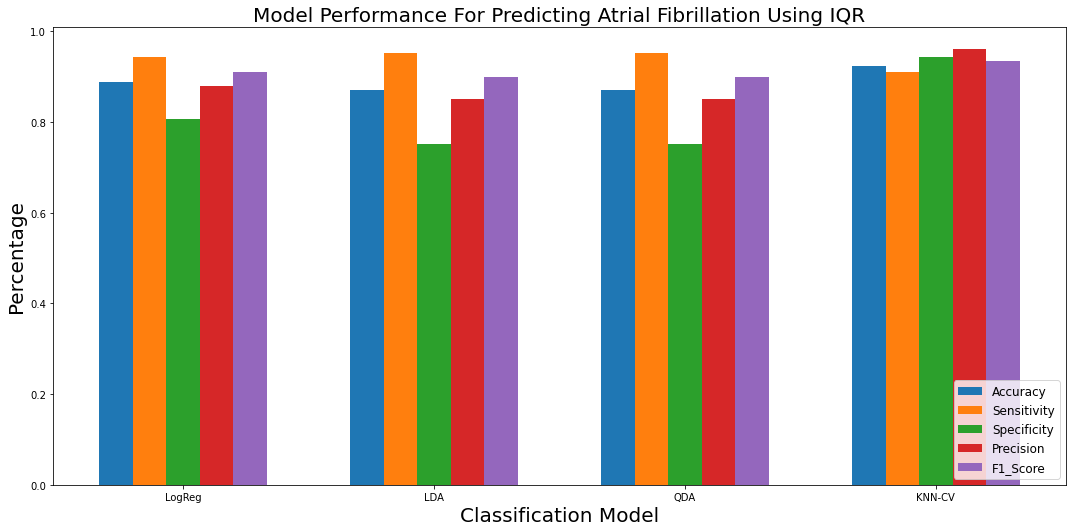

In [21]:
models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']
accuracies = statiqr_dic["Accuracy"]
sensitivities = statiqr_dic["Sensitivity"]
specificities = statiqr_dic["Specificity"]
precisions = statiqr_dic["Precision"]
f1_scores = statiqr_dic["F1_Score"]



x = 6*np.arange(len(models))
width = 0.8

fig, ax = plt.subplots(figsize=(15, 7.5))
acc = ax.bar(x-width*2, accuracies, width, label='Accuracy')
sen = ax.bar(x-width, sensitivities, width, label='Sensitivity')
spe = ax.bar(x,specificities, width, label='Specificity')
pre = ax.bar(x+width, precisions, width, label='Precision')
f1 = ax.bar(x+width*2 , f1_scores, width, label='F1_Score')

ax.set_xlabel('Classification Model', fontsize=20)
ax.set_ylabel('Percentage', fontsize=20)
ax.set_title('Model Performance For Predicting Atrial Fibrillation Using IQR', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()


fig.tight_layout()

plt.legend(loc="lower right", prop={'size': 12})
plt.show()

fig.savefig('IqrModel.png')

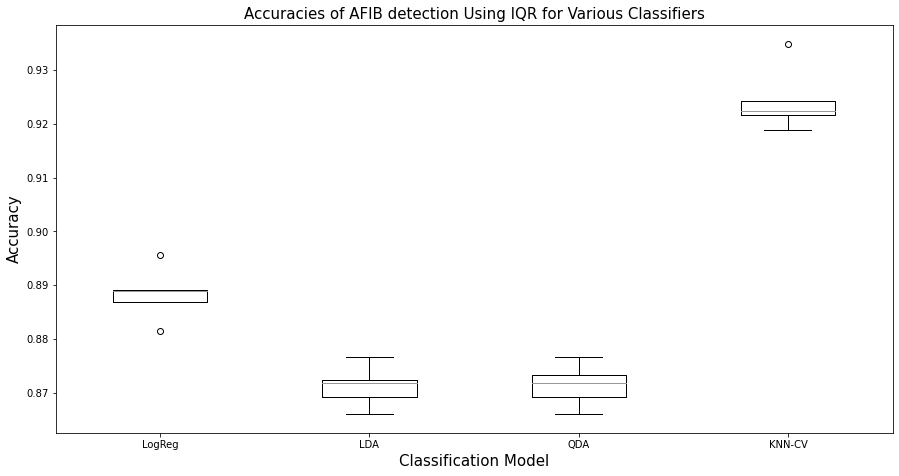

In [22]:
#Box Plots

models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']

x = np.arange(len(models))+1

LogRegAcc = indaccs['LogReg']
LDAAcc = indaccs['LDA']
QDAAcc = indaccs['QDA']
KNNAcc = indaccs['KNN-CV']

data = [LogRegAcc, LDAAcc, QDAAcc, KNNAcc]

fig, ax = plt.subplots(figsize = (15,7.5))
ax.boxplot(data)

ax.set_title('Accuracies of AFIB detection Using IQR for Various Classifiers', fontsize=15)
ax.set_xlabel('Classification Model', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(models)

plt.show()

fig.savefig('IqrBox.png')

In [23]:
iqrdf = pd.DataFrame(
    data = np.transpose(np.array([
                                statiqr_dic["Accuracy"],
                                statiqr_dic["Standard Error"],
                                statiqr_dic["Sensitivity"],
                                statiqr_dic["Specificity"],
                                statiqr_dic["Precision"],
                                statiqr_dic["F1_Score"],
                                statiqr_dic["Run Time"] 
                            ])
                       ),
    
    columns = ["Accuracy", "Standard Error", "Sensitivity", "Specificity", "Precision", "F1-Score", "Run Time"]
    
)

iqrdf.set_index(pd.Index(["LogReg", "LDA", "QDA", "KNN-CV"]))

,Accuracy,Standard Error,Sensitivity,Specificity,Precision,F1-Score,Run Time
LogReg,0.888386,0.004559,0.943529,0.806142,0.878920,0.910079,0.210876
LDA,0.871160,0.003524,0.951920,0.750710,0.850637,0.898433,0.133012
QDA,0.871344,0.003601,0.951817,0.751324,0.850937,0.898554,0.108827
KNN-CV,0.924471,0.005520,0.911201,0.944261,0.960601,0.935250,4.533311
